# Submission Group Assignment Network Science HS22

Participants:

    Alexander Christian Lerch, 17-678-111
    Diego Ricardo Bugmann, 18-472-548
    Szymon Kaczmarski, 21-743-778      

### LIBRARIES & DATASET

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import networkx.algorithms.community as nxcom
from matplotlib import colors as mcolors
from scipy.special import factorial
import pandas as pd
from tabulate import tabulate
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from tqdm import tqdm
import pickle
import powerlaw
import time

In [2]:
# -------------------P A T H S---------------------------
PATH_TWITCH_DE = 'dataset//DE//musae_DE_edges.csv'
PATH_TWITCH_EN = 'dataset//ENGB//musae_ENGB_edges.csv'
PATH_TWITCH_RU = 'dataset//RU//musae_RU_edges.csv'

# ----------------D A T A R E A D -----------------------
with open(PATH_TWITCH_DE, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_DE = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")
with open(PATH_TWITCH_EN, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_EN = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")
with open(PATH_TWITCH_RU, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_RU = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")

# ---------------------S U M M A R Y ----------------------
datasets = [G_TWITCH_DE, G_TWITCH_EN, G_TWITCH_RU]
print(PATH_TWITCH_DE, ' : ', G_TWITCH_DE)
print(PATH_TWITCH_EN, ' : ', G_TWITCH_EN)
print(PATH_TWITCH_RU, ' : ', G_TWITCH_RU)

dataset//DE//musae_DE_edges.csv  :  Graph with 9498 nodes and 153138 edges
dataset//ENGB//musae_ENGB_edges.csv  :  Graph with 7126 nodes and 35324 edges
dataset//RU//musae_RU_edges.csv  :  Graph with 4385 nodes and 37304 edges


In [3]:
# some statistics for each dataset
datasets_names = ['DE', 'EN', 'RU']
for i in range(len(datasets)):
    print("TWITCH " + datasets_names[i])
    print('Average degree: ', round(np.mean(list(dict(datasets[i].degree()).values())),3))
    print('Clustering coefficient: ', round(nx.average_clustering(datasets[i]),3))
    print('Assortativity coefficient: ', round(nx.degree_assortativity_coefficient(datasets[i]),3))
    print('Average shortest distance: ', round(nx.average_shortest_path_length(datasets[i]),3))
    print("----------------------------------------")

TWITCH DE
Average degree:  32.246
Clustering coefficient:  0.201
Assortativity coefficient:  -0.115
Average shortest distance:  2.722
----------------------------------------
TWITCH EN
Average degree:  9.914
Clustering coefficient:  0.131
Assortativity coefficient:  -0.122
Average shortest distance:  3.678
----------------------------------------
TWITCH RU
Average degree:  17.014
Clustering coefficient:  0.166
Assortativity coefficient:  -0.182
Average shortest distance:  3.021
----------------------------------------


In [3]:
PATH_TWITCH_FEATURES_DE = 'dataset//DE//musae_DE_target.csv'
PATH_TWITCH_FEATURES_EN = 'dataset//ENGB//musae_ENGB_target.csv'
PATH_TWITCH_FEATURES_RU = 'dataset//RU//musae_RU_target.csv'
df_features_de = pd.read_csv(PATH_TWITCH_FEATURES_DE, sep=',', header=0, index_col=0)
df_features_en = pd.read_csv(PATH_TWITCH_FEATURES_EN, sep=',', header=0, index_col=0)
df_features_ru = pd.read_csv(PATH_TWITCH_FEATURES_RU, sep=',', header=0, index_col=0)

# ALGORITHMS

In [4]:
ALGORITHMS_NAMES = ['Degree Centrality', 'K-Shell', 'Betweenness Centrality', 'VoteRank', 'PageRank', 'Closeness Centrality', 'Eigenvector Centrality', 'H-Index']

In [7]:
# --------------------- H - i n d e x ----------------------
# https://www.geeksforgeeks.org/what-is-h-index/
def h_index_for_node(G, n):
    # sorting in ascending order
    neighbour_degrees_sorted = sorted((G.degree(v) for v in G.neighbors(n))) 
    # iterating over the list
    for i, node_degree in enumerate(neighbour_degrees_sorted):
        # finding current result
        result = len(neighbour_degrees_sorted) - i
        # if result is less than or equal
        # to node_degree then return result
        if result <= node_degree:
            return result
    return 0

def calculate_h_index(G):
    hindex_list = {}
    for n in G.nodes():
        hindex_list[n] = h_index_for_node(G, n)
    return hindex_list

In [8]:
# --------------------- V o t e R a n k ----------------------
def calculate_voterank(G):
    '''
        [create a dict with value for each node]
        assign max_value to the first node in result_voterank
        assign max_value - 1 to the second node in result_voterank
        ...
        assign -1 to the nodes that are not in result_voterank
    '''
    result_voterank = nx.voterank(G) # returns: Ordered list of computed seeds. Only nodes with positive number of votes are returned.
    dict_voterank = {}
    max_value = len(G.nodes)
    i = 0
    while i < len(result_voterank):
        dict_voterank[result_voterank[i]] = max_value
        max_value -= 1
        i += 1
    for n in G.nodes:
        if n not in dict_voterank:
            dict_voterank[n] = -1
    return dict_voterank

In [9]:
# --------------------- K - s h e l l ----------------------
def calculate_k_shell(G):
    k_shell_nodes_for_shell = {}
    N = 1000
    i = 1
    while i < N:
        list_of_nodes = list(nx.k_shell(G, k = i).nodes)
        if list_of_nodes:
            k_shell_nodes_for_shell[i] = list_of_nodes
        else:
            break
        i += 1
    if i == N:
        print("ERROR - K-Shell algorithm did not converge.")
    k_shell = {}
    for shell, list_of_nodes_per_shell in k_shell_nodes_for_shell.items():
        for node in list_of_nodes_per_shell:
            k_shell[node] = shell
    return k_shell

In [10]:
def run_algorithms(G):
    try: 
        pbar = tqdm(total=len(ALGORITHMS_NAMES))
        results = []
        results.append(nx.degree_centrality(G)) # returns dict
        pbar.update(1)
        results.append(calculate_k_shell(G)) # returns dict
        pbar.update(1)
        results.append(nx.betweenness_centrality(G, seed=123)) # returns dict
        pbar.update(1)
        results.append(calculate_voterank(G)) # returns dict
        pbar.update(1)
        results.append(nx.pagerank(G, weight=None)) # returns dict
        pbar.update(1)
        results.append(nx.closeness_centrality(G)) # returns dict
        pbar.update(1)
        results.append(nx.eigenvector_centrality(G)) # returns dict
        pbar.update(1)
        results.append(calculate_h_index(G)) # returns dict
        pbar.update(1)
        pbar.close()
        for i in range(len(results)):
            if len(results[i]) != len(G.nodes):
                print('ERROR - results for ',ALGORITHMS_NAMES[i], ' is not the same length as G.nodes')
        return results
    except Exception as e:
        print('ERROR - run_algorithms() failed: ', e)

In [11]:
# run for each language
print('Running algorithms for German...')
results_de = run_algorithms(G_TWITCH_DE)
print('Running algorithms for English...')
results_en = run_algorithms(G_TWITCH_EN)
print('Running algorithms for Russian...')
results_ru = run_algorithms(G_TWITCH_RU)
# save the results in results folder as pickle
with open('results//results_de.pickle', 'wb') as handle:
    pickle.dump(results_de, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results//results_en.pickle', 'wb') as handle:
    pickle.dump(results_en, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results//results_ru.pickle', 'wb') as handle:
    pickle.dump(results_ru, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save names of algorithms
with open('results//algorithms_names.pickle', 'wb') as handle:
    pickle.dump(ALGORITHMS_NAMES, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running algorithms for German...


100%|██████████| 8/8 [36:09<00:00, 271.24s/it]


Running algorithms for English...


100%|██████████| 8/8 [08:11<00:00, 61.49s/it] 


Running algorithms for Russian...


100%|██████████| 8/8 [04:01<00:00, 30.19s/it]


In [4]:
# load the results
with open('results//results_de.pickle', 'rb') as handle:
    results_de = pickle.load(handle)
with open('results//results_en.pickle', 'rb') as handle:
    results_en = pickle.load(handle)
with open('results//results_ru.pickle', 'rb') as handle:
    results_ru = pickle.load(handle)
# load names of algorithms
with open('results//algorithms_names.pickle', 'rb') as handle:
    ALGORITHMS_NAMES = pickle.load(handle)

# SIR (Susceptible-Infected-Recovered) model

In [5]:
# ---------- Define certain constants ----------

# Define p
DEFAULT_P = 0.05

# Define p values for varying p
P_VALUES = list(np.logspace(np.log10(0.001), np.log10(0.1), num=7))

# Define beta factors for varying betas
BETA_FACTORS = [1, 1.5, 2, 2.5, 3]

In [6]:
# ---------- Define certain methods used throughout the simulations ----------

# method to calculate the infected scale
def get_infected_scale(infected, recovered, total):
    return (infected + recovered) / total


# method to get the final infected scale
def get_final_infected_scale(simulation, total):
    for timestep in simulation:
        # as soon as no more nodes are infected, return the fraction of the recovered nodes
        if timestep['node_count'][1] == 0:
            return timestep['node_count'][2] / total
    print("Not enough timesteps included to reach a steady state. Enlarge t!")


# method to get beta
def get_beta(network, factor=1.5):
    beta_threshold = get_infection_threshold(network)
    return factor * beta_threshold


# helper method to get the infection threshold
def get_infection_threshold(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    avg_sqrd_degrees = np.mean([d**2 for d in degrees])
    bth = avg_degree / (avg_sqrd_degrees - avg_degree)
    return bth


# method to get gamma
def get_gamma(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    return 4 / avg_degree


# method to fetch the top fraction of each algorithm for a result
def fetch_initial_nodes(results, p=0.01):
    list_of_initial_nodes = []
    n = int(len(results[0]) * p) # define the amount of nodes to be chosen
    for result in results:
        result_sorted = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
        initial_nodes = list(result_sorted)[:n]
        list_of_initial_nodes.append(initial_nodes)
    return list_of_initial_nodes


# method to plot values
def plot_values(x, ys, title, zoomed, x_label="t", y_label="F(t)"):
    markers = ["o", "v", "^", "<", ">", "s", "D", "X"]
    for i, y in enumerate(ys):
        if not zoomed:
            plt.plot(x, y, label=ALGORITHMS_NAMES[i], marker=markers[i], alpha=1)
        else:
            plt.plot(x, y, label=ALGORITHMS_NAMES[i], marker=markers[i], alpha=1, linewidth=3, markersize=10)
    plt.ylabel(y_label, fontsize=24)
    plt.xlabel(x_label, fontsize=24)
    if x_label == 'p':
        plt.xscale('log')
    plt.title(title, fontsize = 30)
    if not zoomed:
        plt.rcParams["figure.figsize"] = (12.8, 9.6)
        plt.legend(loc = 'best', fontsize=15)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
    else:
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
    if zoomed:
        if "EN" in title:
            plt.axis([45, 49, 0.22, 0.25])
        elif "DE" in title:
            plt.axis([90, 99, 0.46, 0.48])
        else:
            plt.axis([45, 49, 0.32, 0.34])
    plt.show()


## Comparing algorithms over time F(t) / t

In [7]:
# method to simulate a model (with all parameters set, over time)
def simulate(network, results, num_of_simulations=100, num_of_t=200, show_bar=True):
    
    # Beta and Gamma is chosen basen on explanation in paragraph 3.2
    beta = get_beta(network)
    gamma = get_gamma(network)
    list_of_initial_nodes = fetch_initial_nodes(results, DEFAULT_P)
    
    # keep track of the y values for each of the algorihms
    ys = []
    
    for initial_nodes in list_of_initial_nodes:
        
        # ---------- Model Configuration ----------
        model = ep.SIRModel(network)
        n = network.number_of_nodes()
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta) # INFECTION PROBABILITY
        cfg.add_model_parameter('gamma', gamma) # RECOVERY PROBABILITY
        cfg.add_model_initial_configuration("Infected", initial_nodes) # INITIALLY INFECTED NODES
        model.set_initial_status(cfg)

        # ---------- Simulation ----------
        # execute the simulations and save them in a list
        simulations = []
        for i in range(num_of_simulations):
            model.reset() # reset so that each simulation starts from scratch
            simulation = model.iteration_bunch(num_of_t, progress_bar=show_bar)
            simulations.append(simulation)

        y = []
        # average out the infected / recovered for each step, calculate the infected_scale and save it to a list
        for i in range(num_of_t):
            infected = np.mean([simulation[i]['node_count'][1] for simulation in simulations]) # get the mean for each step
            recovered = np.mean([simulation[i]['node_count'][2] for simulation in simulations]) # get the mean for each step
            # calculate F(t) and add it to the y-values
            infected_scale_value = get_infected_scale(infected, recovered, n)
            y.append(infected_scale_value)
        
        ys.append(y)
        print("Cycle Done")
    
    x = list(range(num_of_t))
    
    return x, ys


In [8]:
# ------------------------- Run all the simulations -------------------------
# x_EN, ys_EN = simulate(G_TWITCH_EN, results_en, num_of_t=50, show_bar=False)
# x_DE, ys_DE = simulate(G_TWITCH_DE, results_de, num_of_t=100, show_bar=False)
# x_RU, ys_RU = simulate(G_TWITCH_RU, results_ru, num_of_t=50, show_bar=False)

# ------------------------- Save all the values -------------------------
# with open('results//x_EN.pickle', 'wb') as handle:
#     pickle.dump(x_EN, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_EN.pickle', 'wb') as handle:
#     pickle.dump(ys_EN, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_DE.pickle', 'wb') as handle:
#     pickle.dump(x_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_DE.pickle', 'wb') as handle:
#     pickle.dump(ys_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_RU.pickle', 'wb') as handle:
#     pickle.dump(x_RU, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_RU.pickle', 'wb') as handle:
#     pickle.dump(ys_RU, handle, protocol=pickle.HIGHEST_PROTOCOL)

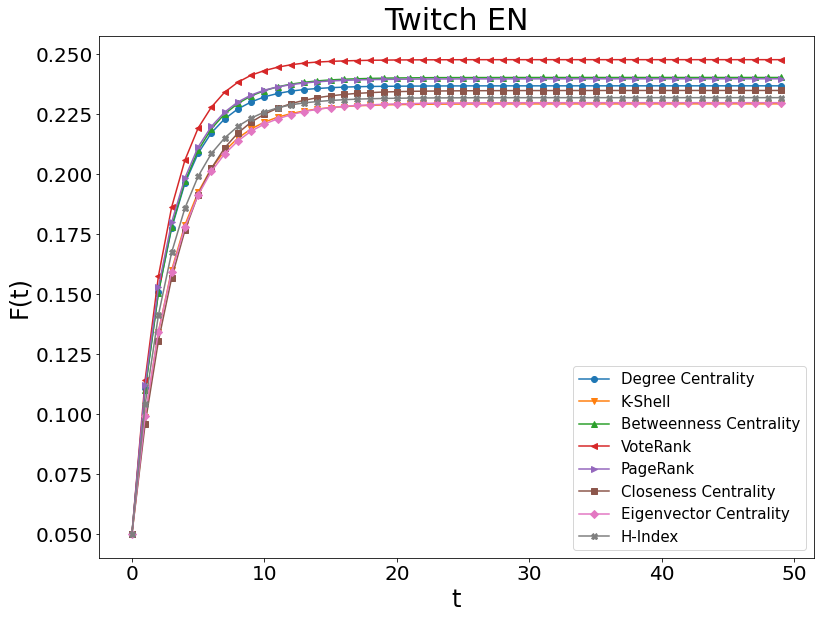

In [10]:
# -------------------- Load and plot the values (EN) --------------------
with open('results//x_EN.pickle', 'rb') as handle:
    x_EN = pickle.load(handle)
with open('results//ys_EN.pickle', 'rb') as handle:
    ys_EN = pickle.load(handle)
plot_values(x_EN, ys_EN, "Twitch EN", False)

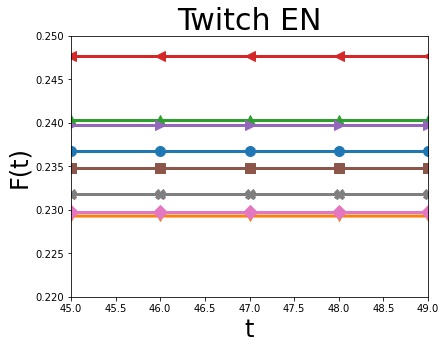

In [12]:
# -------------------- Plot the values zoomed (EN) --------------------
plot_values(x_EN, ys_EN, "Twitch EN", True)

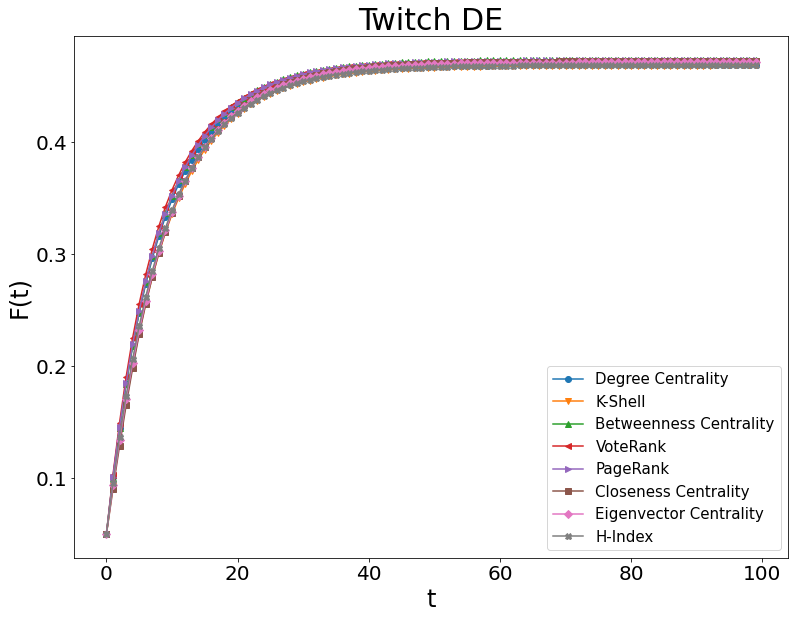

In [14]:
# -------------------- Load and plot the values (DE) --------------------
with open('results//x_DE.pickle', 'rb') as handle:
    x_DE = pickle.load(handle)
with open('results//ys_DE.pickle', 'rb') as handle:
    ys_DE = pickle.load(handle)
plot_values(x_DE, ys_DE, "Twitch DE", False)

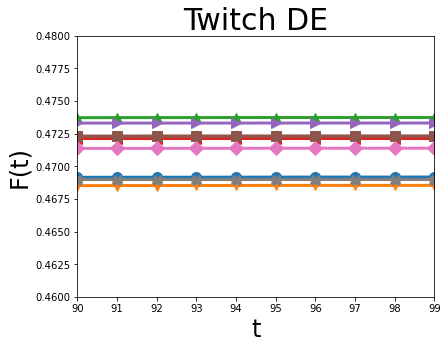

In [16]:
# -------------------- Plot the values zoomed (DE) --------------------
plot_values(x_DE, ys_DE, "Twitch DE", True)

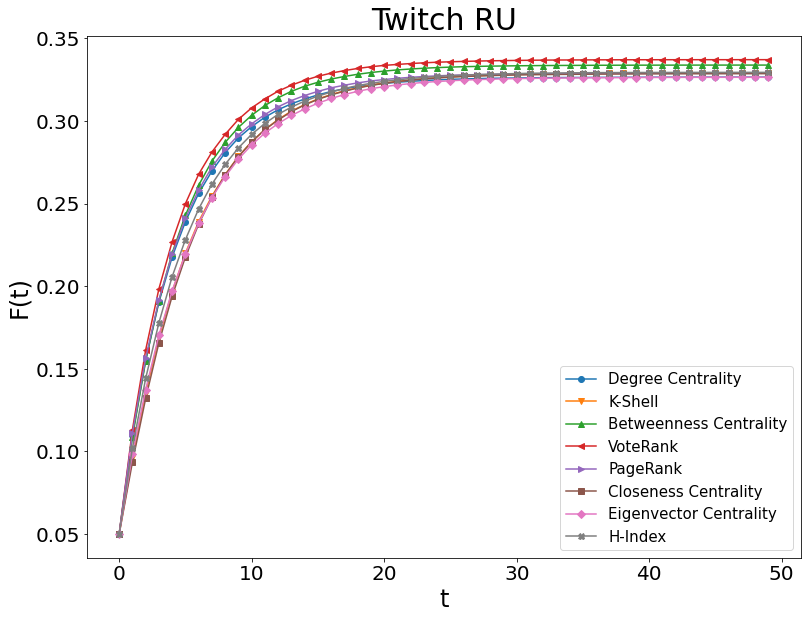

In [18]:
# -------------------- Load and plot the values (RU) --------------------
with open('results//x_RU.pickle', 'rb') as handle:
    x_RU = pickle.load(handle)
with open('results//ys_RU.pickle', 'rb') as handle:
    ys_RU = pickle.load(handle)
plot_values(x_RU, ys_RU, "Twitch RU", False)

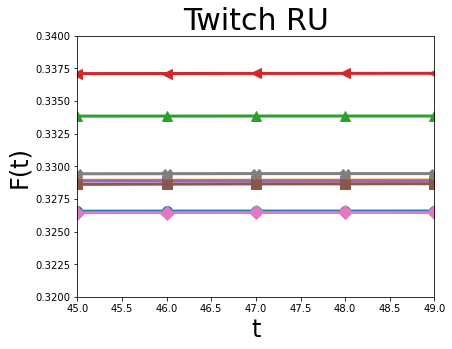

In [20]:
# -------------------- Plot the values zoomed (RU) --------------------
plot_values(x_RU, ys_RU, "Twitch RU", True)

## Comparing different p-values F(tc) / p

In [21]:
# method to simulate a model with varying p values
def simulate_vary_p(network, results, num_of_simulations=100, num_of_t=200, show_bar=True):
    
    # Beta and Gamma is chosen basen on explanation in paragraph 3.2
    beta = get_beta(network)
    gamma = get_gamma(network)
    
    # keep track of the y values for each of the algorihms    
    ys = []
    for i in range(len(results)):
        ys.append([])
    
    for p in P_VALUES:
        
        list_of_initial_nodes = fetch_initial_nodes(results, p)
    
        for i, initial_nodes in enumerate(list_of_initial_nodes):

            # ---------- Model Configuration ----------
            model = ep.SIRModel(network)
            n = network.number_of_nodes()
            cfg = mc.Configuration()
            cfg.add_model_parameter('beta', beta) # INFECTION PROBABILITY
            cfg.add_model_parameter('gamma', gamma) # RECOVERY PROBABILITY
            cfg.add_model_initial_configuration("Infected", initial_nodes) # INITIALLY INFECTED NODES
            model.set_initial_status(cfg)

            # ---------- Simulation ----------
            # execute the simulations and save the final infected scale to a list
            final_infected_scales = []
            for j in range(num_of_simulations):
                model.reset() # reset so that each simulation starts from scratch
                simulation = model.iteration_bunch(num_of_t, progress_bar=show_bar)
                final_infected_scale = get_final_infected_scale(simulation, n)
                final_infected_scales.append(final_infected_scale)
            
            # average out the final infected scale
            final_infected_scale = np.mean(final_infected_scales)
            ys[i].append(final_infected_scale)
            
        print("CYCLE DONE")
    
    x = P_VALUES
    
    return x, ys

In [22]:
# ------------------------- Run all the simulations -------------------------
# x_EN_varyingp, ys_EN_varyingp = simulate_vary_p(G_TWITCH_EN, results_en, num_of_t=100, show_bar=False)
# x_DE_varyingp, ys_DE_varyingp = simulate_vary_p(G_TWITCH_DE, results_de, num_of_t=200, show_bar=False)
# x_RU_varyingp, ys_RU_varyingp = simulate_vary_p(G_TWITCH_RU, results_ru, num_of_t=120, show_bar=False)

# ------------------------- Save all the values -------------------------
# with open('results//x_EN_varyingp.pickle', 'wb') as handle:
#     pickle.dump(x_EN_varyingp, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_EN_varyingp.pickle', 'wb') as handle:
#     pickle.dump(ys_EN_varyingp, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_DE_varyingp.pickle', 'wb') as handle:
#     pickle.dump(x_DE_varyingp, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_DE_varyingp.pickle', 'wb') as handle:
#     pickle.dump(ys_DE_varyingp, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_RU_varyingp.pickle', 'wb') as handle:
#     pickle.dump(x_RU_varyingp, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_RU_varyingp.pickle', 'wb') as handle:
#     pickle.dump(ys_RU_varyingp, handle, protocol=pickle.HIGHEST_PROTOCOL)

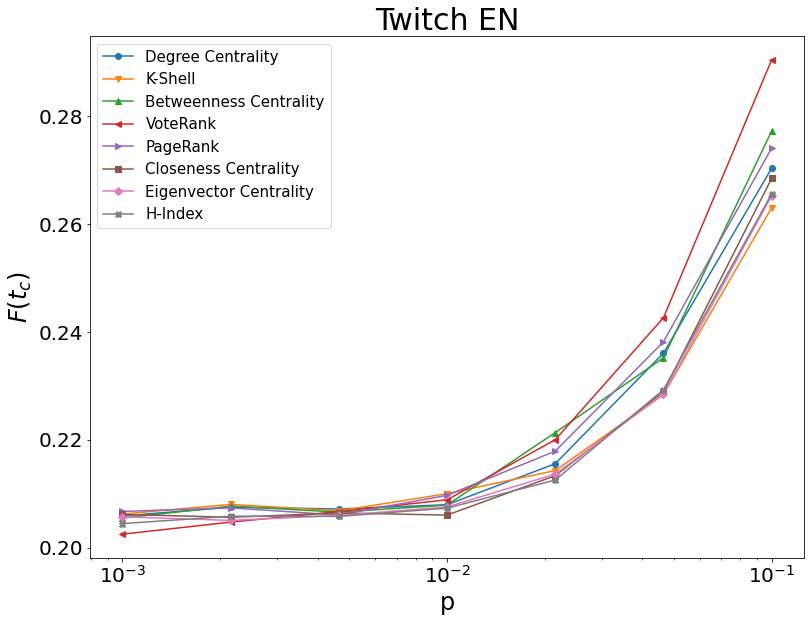

In [24]:
# -------------------- Load and plot the values (EN) --------------------
with open('results//x_EN_varyingp.pickle', 'rb') as handle:
    x_EN_varyingp = pickle.load(handle)
with open('results//ys_EN_varyingp.pickle', 'rb') as handle:
    ys_EN_varyingp = pickle.load(handle)
plot_values(x_EN_varyingp, ys_EN_varyingp, "Twitch EN", False, x_label="p", y_label="$F(t_{c})$")

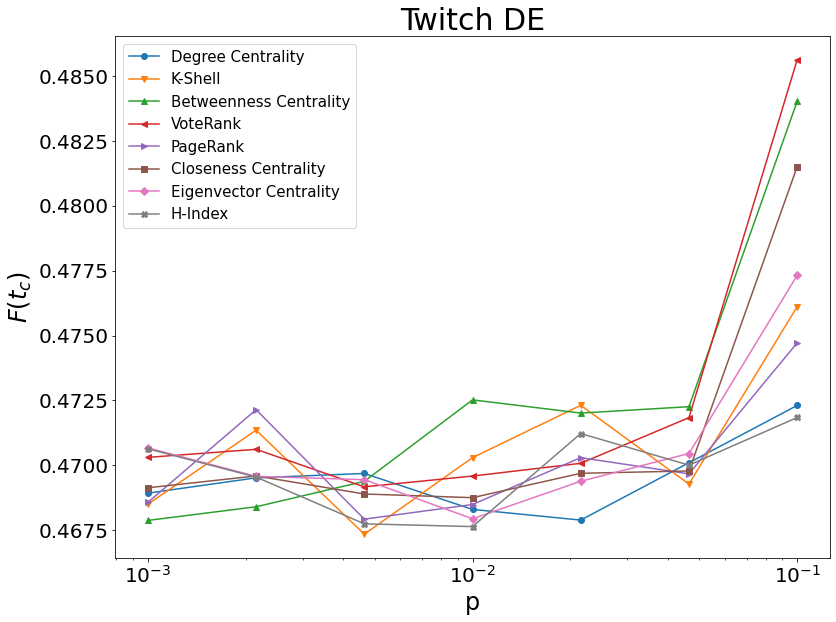

In [25]:
# -------------------- Load and plot the values (DE) --------------------
with open('results//x_DE_varyingp.pickle', 'rb') as handle:
    x_DE_varyingp = pickle.load(handle)
with open('results//ys_DE_varyingp.pickle', 'rb') as handle:
    ys_DE_varyingp = pickle.load(handle)
plot_values(x_DE_varyingp, ys_DE_varyingp, "Twitch DE", False, x_label="p", y_label="$F(t_{c})$")

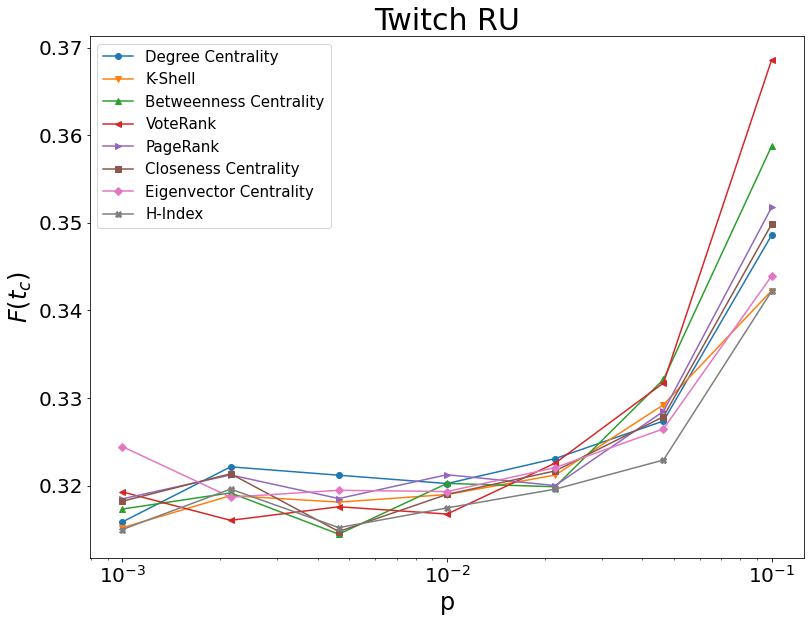

In [26]:
# -------------------- Load and plot the values (RU) --------------------
with open('results//x_RU_varyingp.pickle', 'rb') as handle:
    x_RU_varyingp = pickle.load(handle)
with open('results//ys_RU_varyingp.pickle', 'rb') as handle:
    ys_RU_varyingp = pickle.load(handle)
plot_values(x_RU_varyingp, ys_RU_varyingp, "Twitch RU", False, x_label="p", y_label="$F(t_{c})$")

## Comparing different beta-values F(tc) / beta

In [27]:
# method to simulate a model with varying beta values
def simulate_vary_beta(network, results, num_of_simulations=100, num_of_t=200, show_bar=True):
    
    # Gamma is chosen basen on explanation in paragraph 3.2
    gamma = get_gamma(network)
    list_of_initial_nodes = fetch_initial_nodes(results, DEFAULT_P)
    
    # Betas are fetched accoring to the different factors
    betas = []
    for factor in BETA_FACTORS:
        beta = get_beta(network, factor)
        betas.append(beta)
    
    # keep track of the y values for each of the algorihms
    ys = []
    for i in range(len(results)):
        ys.append([])
    
    for beta in betas:
    
        for i, initial_nodes in enumerate(list_of_initial_nodes):

            # ---------- Model Configuration ----------
            model = ep.SIRModel(network)
            n = network.number_of_nodes()
            cfg = mc.Configuration()
            cfg.add_model_parameter('beta', beta) # INFECTION PROBABILITY
            cfg.add_model_parameter('gamma', gamma) # RECOVERY PROBABILITY
            cfg.add_model_initial_configuration("Infected", initial_nodes) # INITIALLY INFECTED NODES
            model.set_initial_status(cfg)

            # ---------- Simulation ----------
            # execute the simulations and save the final infected scale to a list
            final_infected_scales = []
            for j in range(num_of_simulations):
                model.reset() # reset so that each simulation starts from scratch
                simulation = model.iteration_bunch(num_of_t, progress_bar=show_bar)
                final_infected_scale = get_final_infected_scale(simulation, n)
                final_infected_scales.append(final_infected_scale)
            
            # average out the final infected scale
            final_infected_scale = np.mean(final_infected_scales)
            ys[i].append(final_infected_scale)
            
        print("CYCLE DONE")
    
    x = BETA_FACTORS
    
    return x, ys


In [28]:
# ------------------------- Run all the simulations -------------------------
# x_EN_varyingb, ys_EN_varyingb = simulate_vary_beta(G_TWITCH_EN, results_en, num_of_t=100, show_bar=False)
# x_DE_varyingb, ys_DE_varyingb = simulate_vary_beta(G_TWITCH_DE, results_de, num_of_t=200, show_bar=False)
# x_RU_varyingb, ys_RU_varyingb = simulate_vary_beta(G_TWITCH_RU, results_ru, num_of_t=120, show_bar=False)

# ------------------------- Save all the values -------------------------
# with open('results//x_EN_varyingb.pickle', 'wb') as handle:
#     pickle.dump(x_EN_varyingb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_EN_varyingb.pickle', 'wb') as handle:
#     pickle.dump(ys_EN_varyingb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_DE_varyingb.pickle', 'wb') as handle:
#     pickle.dump(x_DE_varyingb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_DE_varyingb.pickle', 'wb') as handle:
#     pickle.dump(ys_DE_varyingb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_RU_varyingb.pickle', 'wb') as handle:
#     pickle.dump(x_RU_varyingb, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//ys_RU_varyingb.pickle', 'wb') as handle:
#     pickle.dump(ys_RU_varyingb, handle, protocol=pickle.HIGHEST_PROTOCOL)

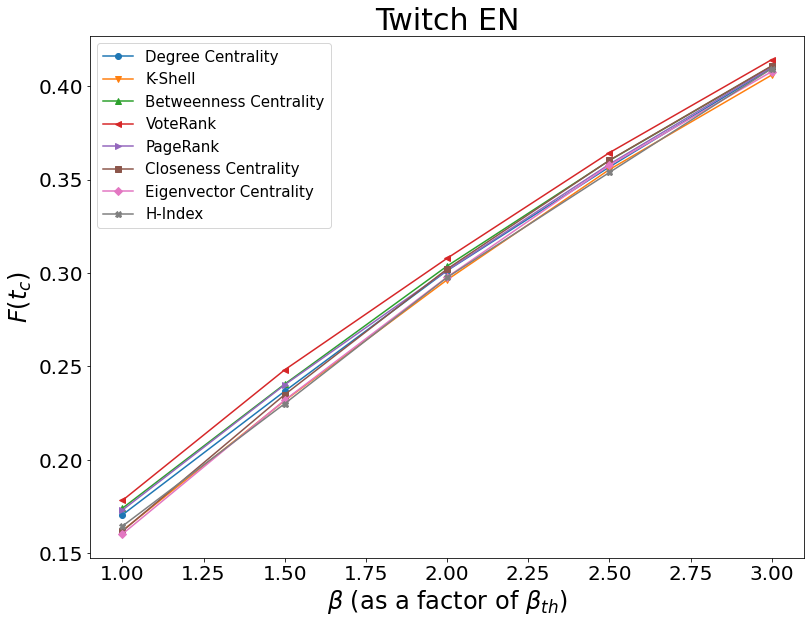

In [29]:
# -------------------- Load and plot the values (EN) --------------------
with open('results//x_EN_varyingb.pickle', 'rb') as handle:
    x_EN_varyingb = pickle.load(handle)
with open('results//ys_EN_varyingb.pickle', 'rb') as handle:
    ys_EN_varyingb = pickle.load(handle)
plot_values(x_EN_varyingb, ys_EN_varyingb, "Twitch EN", False, x_label=r'$\beta$ (as a factor of $\beta_{th}$)', y_label="$F(t_{c})$")

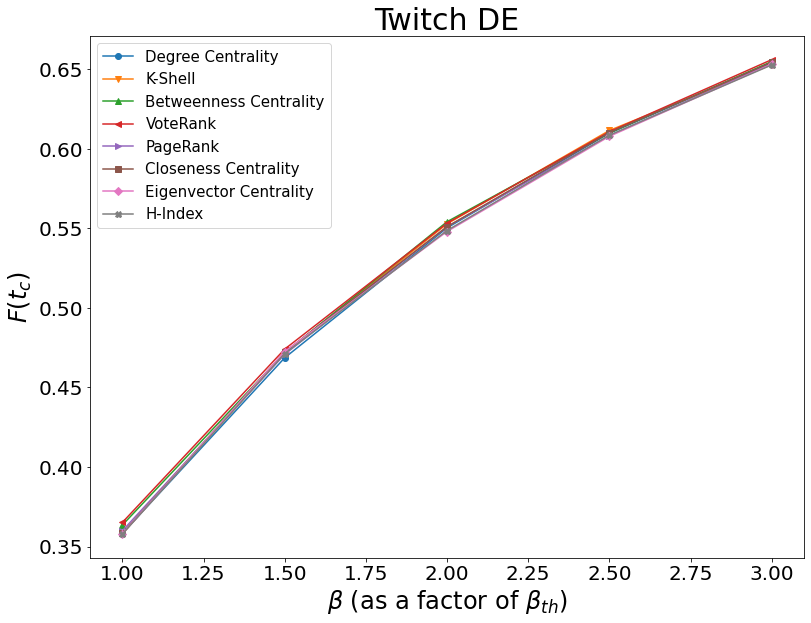

In [30]:
# -------------------- Load and plot the values (DE) --------------------
with open('results//x_DE_varyingb.pickle', 'rb') as handle:
    x_DE_varyingb = pickle.load(handle)
with open('results//ys_DE_varyingb.pickle', 'rb') as handle:
    ys_DE_varyingb = pickle.load(handle)
plot_values(x_DE_varyingb, ys_DE_varyingb, "Twitch DE", False, x_label=r'$\beta$ (as a factor of $\beta_{th}$)', y_label="$F(t_{c})$")

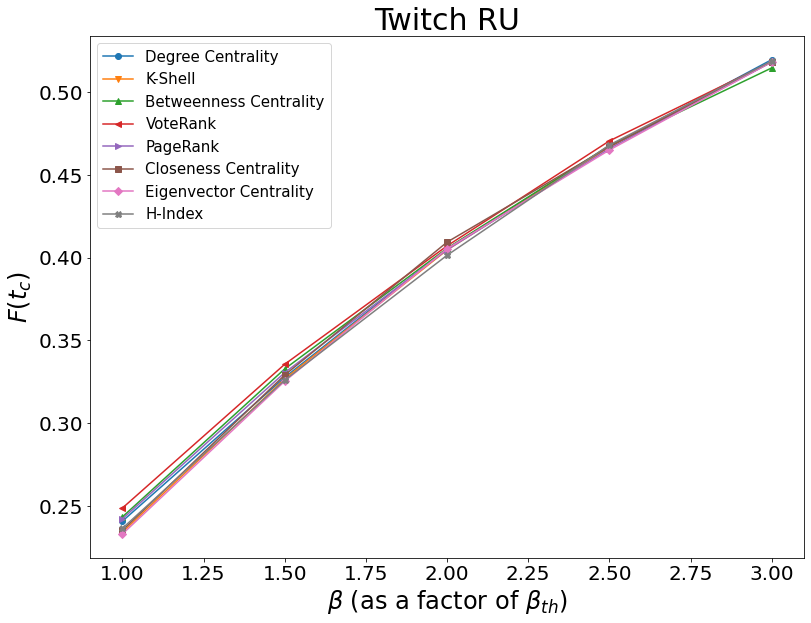

In [31]:
# -------------------- Load and plot the values (RU) --------------------
with open('results//x_RU_varyingb.pickle', 'rb') as handle:
    x_RU_varyingb = pickle.load(handle)
with open('results//ys_RU_varyingb.pickle', 'rb') as handle:
    ys_RU_varyingb = pickle.load(handle)
plot_values(x_RU_varyingb, ys_RU_varyingb, "Twitch RU", False, x_label=r'$\beta$ (as a factor of $\beta_{th}$)', y_label="$F(t_{c})$")

## Comparing average shortest path lengths (Ls / p)

In [67]:
# method to calculate the avg shortest path for a subset of nodes in a graph
def avg_shortest_path(network, initial_nodes):
    
    shortest_paths = []
    
    for i, startnode in enumerate(initial_nodes):
        for j in range(i+1, len(initial_nodes)):
            endnode = initial_nodes[j]
            shortest_path = nx.shortest_path_length(network, startnode, endnode)
            shortest_paths.append(shortest_path)
    
    avg_shortest_path = np.mean(shortest_paths)
    return avg_shortest_path


# method to calculate the avg. shortest path length for the initial nodes (all algs, different p)
def calculate_avg_shortest_paths(network, result):

    y_values = [[],[],[],[],[],[],[],[]]

    for p in P_VALUES:

        list_of_initial_nodes = fetch_initial_nodes(result, p)

        for i, node_list in enumerate(list_of_initial_nodes):
            Ls = avg_shortest_path(network, node_list)
            y_values[i].append(Ls)
        
    x_values = P_VALUES
    return x_values, y_values

In [66]:
# ------------------------- Calculate the results -------------------------
# x_asp_EN, y_asp_EN = calculate_avg_shortest_paths(G_TWITCH_EN, results_en)
# x_asp_DE, y_asp_DE = calculate_avg_shortest_paths(G_TWITCH_DE, results_de)
# x_asp_RU, y_asp_RU = calculate_avg_shortest_paths(G_TWITCH_RU, results_ru)

# ------------------------- Save all the values -------------------------
# with open('results//x_asp_EN.pickle', 'wb') as handle:
#     pickle.dump(x_asp_EN, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//y_asp_EN.pickle', 'wb') as handle:
#     pickle.dump(y_asp_EN, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_asp_DE.pickle', 'wb') as handle:
#     pickle.dump(x_asp_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//y_asp_DE.pickle', 'wb') as handle:
#     pickle.dump(y_asp_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//x_asp_RU.pickle', 'wb') as handle:
#     pickle.dump(x_asp_RU, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('results//y_asp_RU.pickle', 'wb') as handle:
#     pickle.dump(y_asp_RU, handle, protocol=pickle.HIGHEST_PROTOCOL)

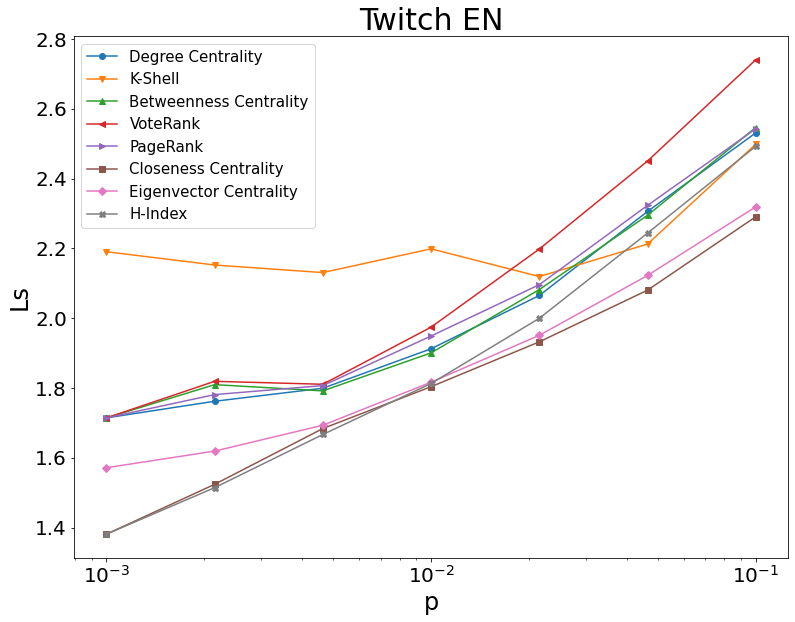

In [63]:
# -------------------- Load and plot the values (EN) --------------------
with open('results//x_asp_EN.pickle', 'rb') as handle:
    x_asp_EN = pickle.load(handle)
with open('results//y_asp_EN.pickle', 'rb') as handle:
    y_asp_EN = pickle.load(handle)
plot_values(x_asp_EN, y_asp_EN, "Twitch EN", False, x_label='p', y_label='Ls')

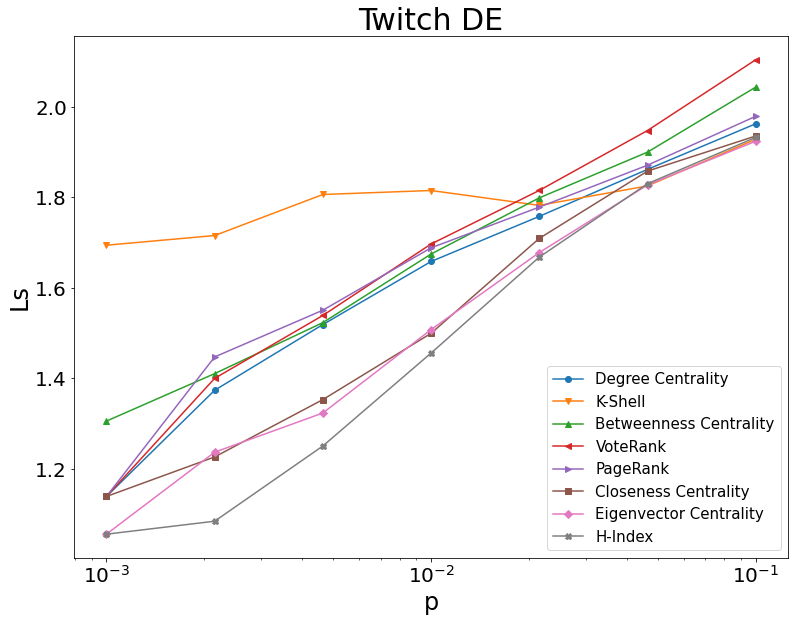

In [64]:
# -------------------- Load and plot the values (DE) --------------------
with open('results//x_asp_DE.pickle', 'rb') as handle:
    x_asp_DE = pickle.load(handle)
with open('results//y_asp_DE.pickle', 'rb') as handle:
    y_asp_DE = pickle.load(handle)
plot_values(x_asp_DE, y_asp_DE, "Twitch DE", False, x_label='p', y_label='Ls')

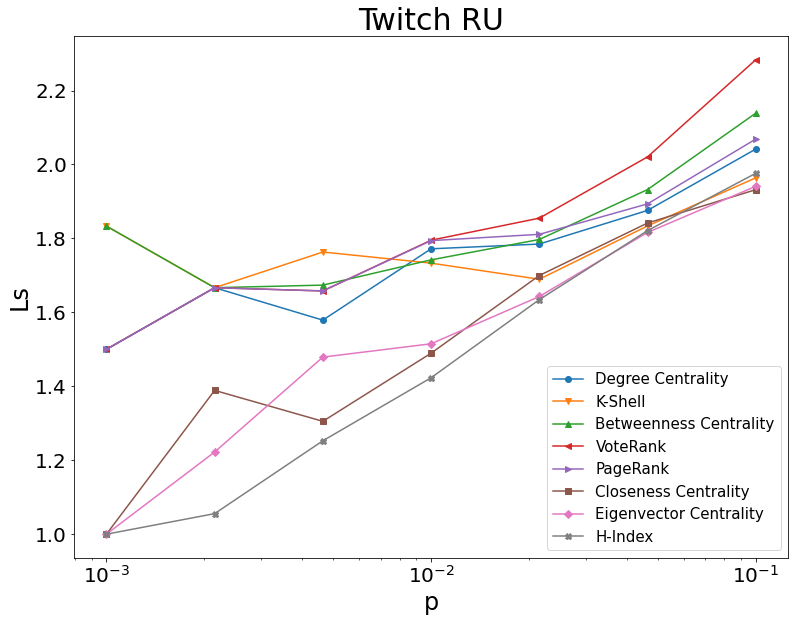

In [65]:
# -------------------- Load and plot the values (RU) --------------------
with open('results//x_asp_RU.pickle', 'rb') as handle:
    x_asp_RU = pickle.load(handle)
with open('results//y_asp_RU.pickle', 'rb') as handle:
    y_asp_RU = pickle.load(handle)
plot_values(x_asp_RU, y_asp_RU, "Twitch RU", False, x_label='p', y_label='Ls')